<div width="100%">
    <img width="100%" src="https://storage.googleapis.com/kaggle-datasets-images/1232095/2056195/3da2fe161c2e35efefa75f990b545d32/dataset-cover.png" />
</div>

In [1]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer

from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt

<h1 id="dataset" style="color:#black; background:#a6e22d; border:0.5px dotted #black;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [2]:
def load_sentences(filepath):

    final = []
    sentences = []

    with open(filepath, 'r') as f:
        
        for line in f.readlines():
            
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    
    return final

In [3]:
base_path = '../input/conll003-englishversion/'

train_samples = load_sentences(base_path + 'train.txt')
test_samples = load_sentences(base_path + 'test.txt')
valid_samples = load_sentences(base_path + 'valid.txt')

samples = train_samples + test_samples

schema = ['_'] + sorted({tag for sentence in samples 
                             for _, tag in sentence})

<h1 id="model" style="color:#black; background:#ef60b4; border:0.5px dotted #black;"> 
    <center>Model
        <a class="anchor-link" href="#model" target="_self">¶</a>
    </center>
</h1>

In [4]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-cased' 

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema))
model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME, 
                                                          config=config)
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  107719680 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  7690      
Total params: 107,727,370
Trainable params: 107,727,370
Non-trainable params: 0
_________________________________________________________________


<h1 id="tokenize" style="color:#black; background:#fc9720; border:0.5px dotted #black;"> 
    <center>Tokenize
        <a class="anchor-link" href="#tokenize" target="_self">¶</a>
    </center>
</h1>

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_sample(sample):
    seq = [
               (subtoken, tag)
               for token, tag in sample
               for subtoken in tokenizer(token)['input_ids'][1:-1]
           ]
    return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples):
    tag_index = {tag: i for i, tag in enumerate(schema)}
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

14041it [00:16, 832.79it/s]
3453it [00:03, 891.06it/s] 
3250it [00:03, 826.28it/s]


<h1 id="training" style="color:#black; background:#bababa; border:0.5px dotted #black;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [6]:
EPOCHS=5
BATCH_SIZE=8

optimizer = tf.keras.optimizers.Adam(lr=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(tf.constant(X_train), tf.constant(y_train),
                    validation_data=(X_test, y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE)

Epoch 1/5
1756/1756 [==============================] - 421s 226ms/step - loss: 0.2703 - accuracy: 0.9416 - val_loss: 0.0619 - val_accuracy: 0.9820
Epoch 2/5
1756/1756 [==============================] - 394s 224ms/step - loss: 0.0516 - accuracy: 0.9857 - val_loss: 0.0343 - val_accuracy: 0.9902
Epoch 3/5
1756/1756 [==============================] - 395s 225ms/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.0261 - val_accuracy: 0.9924
Epoch 4/5
1756/1756 [==============================] - 397s 226ms/step - loss: 0.0207 - accuracy: 0.9940 - val_loss: 0.0215 - val_accuracy: 0.9938
Epoch 5/5
1756/1756 [==============================] - 398s 226ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0201 - val_accuracy: 0.9944


<h1 id="results" style="color:#black; background:#2fbbab; border:0.5px dotted #black;"> 
    <center>Results
        <a class="anchor-link" href="#results" target="_self">¶</a>
    </center>
</h1>

## Training results

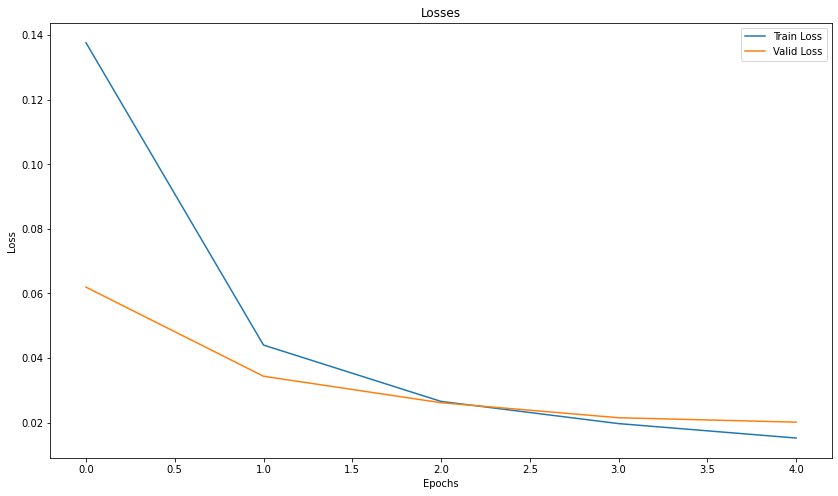

In [7]:
plt.figure(figsize=(14,8))
plt.title('Losses')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

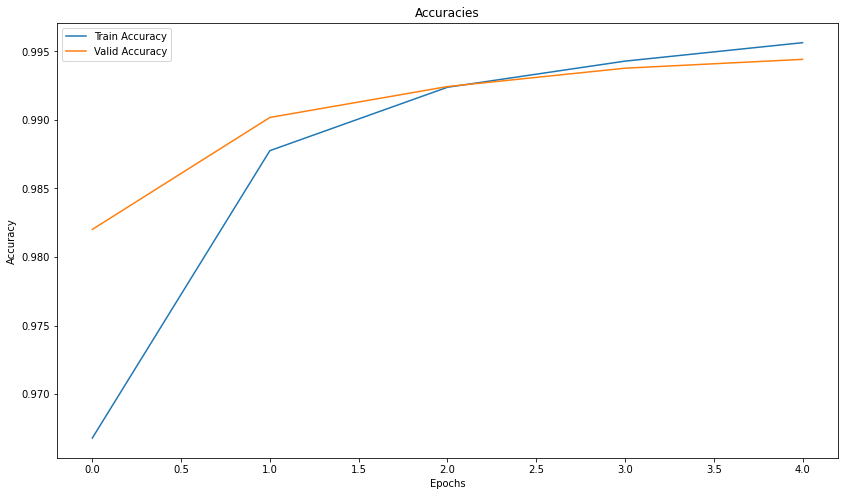

In [8]:
plt.figure(figsize=(14,8))
plt.title('Accuracies')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Validation results

In [9]:
[loss, accuracy] = model.evaluate(X_valid, y_valid)
print("Loss:%1.3f, Accuracy:%1.3f" % (loss, accuracy))

102/102 [==============================] - 25s 211ms/step - loss: 0.0152 - accuracy: 0.9958
Loss:0.015, Accuracy:0.996
